# Assignment 2

Welcome to the assignment for week 2.

## Task 2: Convolution and Canny edge detection

### Task 2.1: Convolution
Implement the convolution operation for 2-D images (i.e. no colors here, sorry).

In [187]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage import io, color

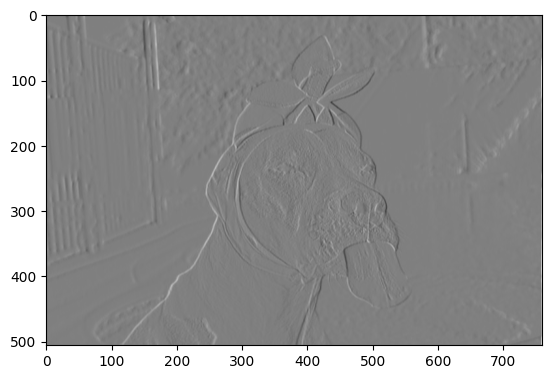

In [188]:
def conv2d(image, kernel):
    # here goes your code
    image = np.array(image)
    kernel = np.array(kernel,dtype=np.float32)
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    padded_w = kernel_width//2
    padded_image = np.pad(image, pad_width=padded_w, mode='constant', constant_values=0)
    result = np.zeros((image_height,image_width))

    for i in range (image_height):
        for j in range (image_width):
            region = padded_image[i:i+kernel_height,j:j+kernel_width]
            result[i,j] = np.sum(region*kernel)
    return result

image = color.rgb2gray(io.imread('images/dog.jpg'))

plt.imshow(conv2d(image, [[1, 0, -1],[1, 0, -1],[1, 0, -1]]), cmap='gray')

Convolve an image of your choice with a Gaussian kernel. Play around with the size of the kernel and the standard deviation of the Gaussian. Show the results using your conv2d()-function.  (***RESULT***).

KeyboardInterrupt: 

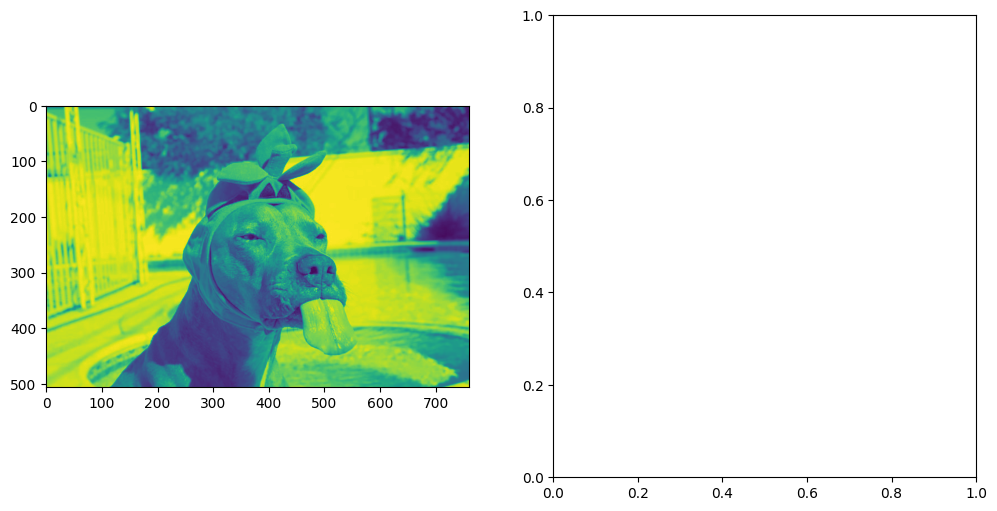

In [189]:
image = cv2.imread('images/dog.jpg')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_cv = gray_image.astype(np.uint8)
kernel_size = (5,5)
sigma = 0.1 #standard deviatation

fig, axes = plt.subplots(1, 2, figsize=(12, 6))


smoothed_image = cv2.GaussianBlur(image_cv,kernel_size,sigmaX= sigma, sigmaY= sigma)

axes[0].imshow(smoothed_image)
axes[1].imshow(conv2d(smoothed_image, [[1, 0, -1],[1, 0, -1],[1, 0, -1]]), cmap='gray')
plt.show()

Now, implement a simple edge detector by first filtering with a Sobel operator and then thresholding the ***RESULT***. How does smoothing the input change the ***RESULT***?

In [ ]:
def Sobel(image):
    #image = cv2.imread(image)

    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=np.float32)

    sobel_y = np.array([[-1, -2, -1],
                        [ 0,  0,  0],
                        [ 1,  2,  1]], dtype=np.float32)

    grad_x = cv2.filter2D(image, -1, sobel_x)
    grad_y = cv2.filter2D(image, -1, sobel_y)

    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    gradient_magnitude = np.uint8(gradient_magnitude)

    gradient_orientation = np.arctan2(grad_x,grad_y)
    gradient_orientation = np.degrees(gradient_orientation)

    gradient_orientation = np.round(gradient_orientation/45) * 45 % 360

    return gradient_magnitude , gradient_orientation



### Task 2.2: Canny Edge Detection

#### Preprocessing
If you haven't yet: smooth the image with a Gaussian of your choice. Then use the Sobel operator to create the gradient magnitude and direction matrices according to the lecture. Round the gradient directions to the 8-neighbor's directions. Display all intermediate ***RESULT***s!

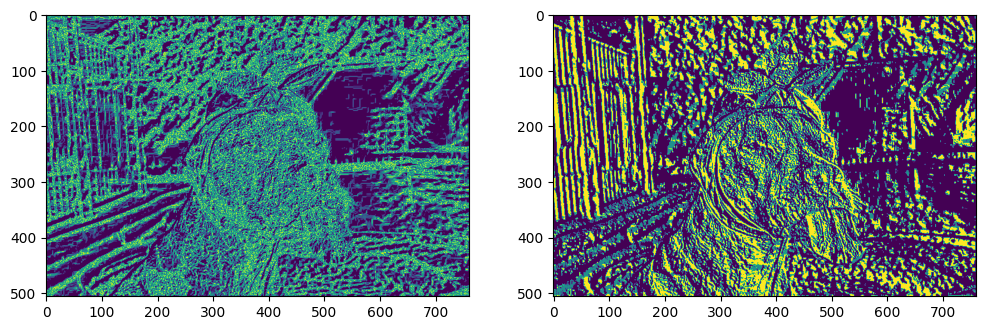

In [ ]:
gradiant_magnitude,gradient_orientation = Sobel(smoothed_image)
fig,axes = plt.subplots(1,2, figsize = (12,6))
axes[0].imshow(gradiant_magnitude)
axes[1].imshow(gradient_orientation)
plt.show()

#### Non-Maximum Suppression
Implement the Non-Maximum Suppression step as described in the lecture. Subtract the result from the gradient magnitude image and show the ***RESULT***!

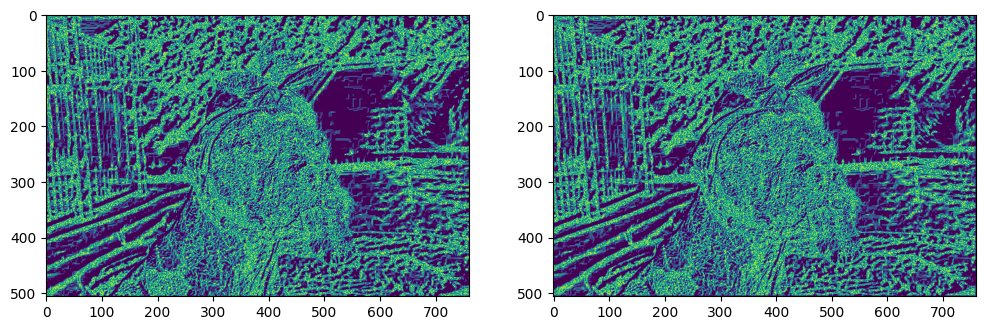

In [ ]:
def non_max_supp(gradient_magnitude,gradient_orientation):
    suppresssed_image = np.zeros_like(gradient_magnitude)
    height, width = gradient_magnitude.shape

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            angel = gradient_orientation[i,j]

            if (angel < 22.5) or (angel > 157.5):
                neigbor1 = gradient_magnitude[i,j+1]
                neigbor2 = gradient_magnitude[1,j-1]
            elif(22.5 <= angel < 67.5):
                neigbor1 = gradient_magnitude[i+1,j-1]
                neigbor2 = gradient_magnitude[i-1,j+1]
            elif(67.5 <= angel < 112.5):
                neigbor1 = gradient_magnitude[i+1,j]
                neigbor2 = gradient_magnitude[i-1,j]
            else:
                neigbor1 = gradient_magnitude[i-1,j+1]
                neigbor2 = gradient_magnitude[i+1,j-1]

            if (gradient_magnitude[i,j] >= neigbor1,neigbor2): #and (gradiant_magnitude[i,j] > neigbor2):
                suppresssed_image[i,j] = gradient_magnitude[i,j]
            else:
                suppresssed_image[i,j] = 0

    return suppresssed_image


grad_mag = non_max_supp(gradiant_magnitude,gradient_orientation)
fig,axes = plt.subplots(1,2, figsize = (12,6))
axes[0].imshow(gradiant_magnitude)
axes[1].imshow(non_max_supp(gradiant_magnitude,gradient_orientation))
plt.show()




#### Thresholding and Edge Tracing
Implement the edge tracing as described in the lecture and show the final result for three different threshold pairs: two low thresholds (e.g. 20 and 50), high thresholds (e.g. 80 and 120) and thresholds with large spacing (e.g. 40 and 140). (***RESULT***)

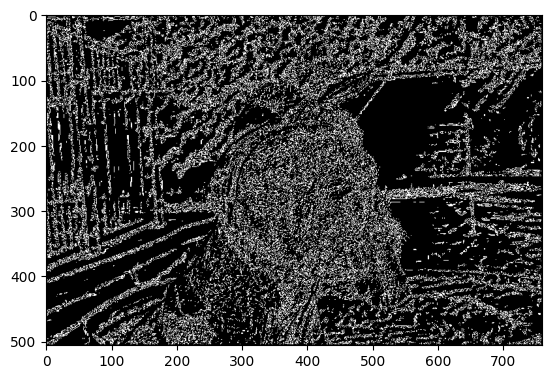

In [195]:
def edge_tracing_by_hysteresis(strong_edges, weak_edges):
    # Create a copy of the strong edges
    final_edges = np.copy(strong_edges)

    # Create a mask for weak edges to be traced
    visited = np.zeros_like(weak_edges, dtype=np.bool_)

    # Get the dimensions of the image
    height, width = weak_edges.shape

    # Define 8-connected neighborhood directions
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]

    # Recursive function to trace weak edges connected to strong edges
    def trace_edge(i, j):
        # If the current pixel is out of bounds or already visited, stop
        if i < 0 or i >= height or j < 0 or j >= width or visited[i, j] or weak_edges[i, j] == 0:
            return

        # Mark the current weak edge pixel as visited
        visited[i, j] = True

        # Add the pixel to the final edges (connected to strong edge)
        final_edges[i, j] = 255  # Set it as part of the edge

        # Trace all 8 neighbors
        for di, dj in directions:
            ni, nj = i + di, j + dj
            if ni >= 0 and ni < height and nj >= 0 and nj < width:
                # Recursively trace the connected weak edges
                if strong_edges[ni, nj] == 255:  # Only trace if it is connected to strong edge
                    trace_edge(ni, nj)

    # Trace all weak edges connected to strong edges
    for i in range(height):
        for j in range(width):
            if strong_edges[i, j] == 255:  # If it's a strong edge, start tracing
                trace_edge(i, j)

    return final_edges

low_threshold = 50
high_threshold = 200
grad_mag = (grad_mag/grad_mag.max())* 255
strong_edges = np.zeros_like(grad_mag, dtype=np.uint8)
weak_edges = np.zeros_like(grad_mag, dtype=np.uint8)

strong_edges[grad_mag > high_threshold] = 255 
weak_edges[(grad_mag >= low_threshold) & (grad_mag <= high_threshold)] = 255

final_edges = edge_tracing_by_hysteresis(strong_edges, weak_edges)

plt.imshow(final_edges, cmap='gray')
plt.show()

## Congratz, you made it! :)